In [1]:
import matplotlib.pyplot as plt
import numpy as np
import herringbone as hb


plt.rcParams['font.family'] = 'DejaVu Serif'

All initialization tests passed.
imported herringbone without any errors :)


## 1. Plots for introduction

## 4. Monte Carlo Algorithms

### 4.1. Prediction

To analyse the prediction task of monte carlo we use the map from example 4.1. of the book. It has a terminal state in the top left and bottom right corner, a gamma of 1, and a reward of -1 for each state.

In [2]:
state_path = "herringbone/env_core/config/state_config.json"
map_path = f"herringbone/env_core/maps/slides.csv"
action_path = "herringbone/env_core/config/action_config.json"

gamma = 1

demo_mdp = hb.MDP(state_path, map_path, action_path, seed=42, gamma=gamma)

In [3]:
"""Ground truth based on example 4.1. from Andrew Barto en Richard S. Sutton's Reinforcement Learning: An Introduction"""

states = demo_mdp.get_states()
values = [0.0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0.0]
exact_value_function = dict(zip(states, values))

hb.Render.preview_V(demo_mdp, exact_value_function)


╔════════╦════════╦════════╦════════╗
║  0.00  ║ -14.00 ║ -20.00 ║ -22.00 ║
╠════════╬════════╬════════╬════════╣
║ -14.00 ║ -18.00 ║ -20.00 ║ -20.00 ║
╠════════╬════════╬════════╬════════╣
║ -20.00 ║ -20.00 ║ -18.00 ║ -14.00 ║
╠════════╬════════╬════════╬════════╣
║ -22.00 ║ -20.00 ║ -14.00 ║  0.00  ║
╚════════╩════════╩════════╩════════╝


In [4]:
random_policy = hb.Policy(mdp=demo_mdp)
episode = hb.Episode(mdp=demo_mdp, policy=random_policy, max_depth=1000)
episode.peek()

╔═══════╦═══════╦═══════╦═══════╗
║   -1  ║   -1  ║   -1  ║   -1  ║
╠═══════╬═══════╬═══════╬═══════╣
║   -1  ║   -1  ║   -1  ║   -1  ║
╠═══════╬═══════╬═══════╬═══════╣
║   -1  ║   -1  ║   -1  ║   -1  ║
╠═══════╬═══════╬═══════╬═══════╣
║   -1  ║   -1  ║   -1  ║   -1  ║
╚═══════╩═══════╩═══════╩═══════╝[0]


As a metric the root mean squared error is used, over all V(s).

In [5]:
def calc_state_value_rms(truth, predicted):
    y, y_pred = np.array(list(truth.values())), np.array(list(predicted.values()))
    return np.sqrt(np.mean((y - y_pred) ** 2))

The monte carlo predictor estimates the value function, while saving snapshots in between.

In [6]:
steps = 100_000
step_size = 1
rms_over_time = []
mc_predictor = hb.MonteCarloPredictor(demo_mdp)
for i in range(steps):
    mc_predictor.evaluate_policy(policy=random_policy,n_samples=step_size)
    rms_over_time.append(calc_state_value_rms(exact_value_function, mc_predictor.value_functions))
    
# Estimated time: less than 20 seconds.
  

Our predicted estimated values are very close to our ground truth:

In [7]:
hb.Render.preview_V(demo_mdp, mc_predictor.value_functions)

╔════════╦════════╦════════╦════════╗
║  0.00  ║ -13.86 ║ -19.94 ║ -21.96 ║
╠════════╬════════╬════════╬════════╣
║ -13.90 ║ -17.93 ║ -19.92 ║ -19.95 ║
╠════════╬════════╬════════╬════════╣
║ -20.00 ║ -19.96 ║ -17.95 ║ -14.01 ║
╠════════╬════════╬════════╬════════╣
║ -21.93 ║ -19.92 ║ -14.02 ║  0.00  ║
╚════════╩════════╩════════╩════════╝


The snapshots are plotted at two different scales, to show that the monte carlo algortihm slowly converges to the actual value functions under the policy.

In [8]:
def plot_v_rms(rms, stop1, stop2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

    # Zoomed in plot
    axes[0].plot(range(len(rms[:stop1])), rms[:stop1], linestyle='-', color="red", label="Zoomed-in View")
    axes[0].set_title(f'First {stop1} steps')
    axes[0].set_xlabel(f'Episodes')
    axes[0].set_ylabel('RMS')
    axes[0].grid(True)
    axes[0].legend()

    # Full scale plot
    axes[1].plot(range(len(rms[:stop2])), rms[:stop2], linestyle='-', color="blue", label="Larger Scale View")
    axes[1].set_title(f'First {stop2} steps')
    axes[1].set_xlabel(f'Episodes')
    axes[1].set_ylabel('RMS')
    axes[1].grid(True)
    axes[1].legend()

    fig.suptitle('First Visit Monte Carlo Prediction', fontsize=14)

    fig.text(0.5, 0.92, 'Comparison of RMS over $v_{\\pi}(s)$ for all $s \\in S$', 
         fontsize=12, ha='center')
    plt.tight_layout()  
    plt.show()

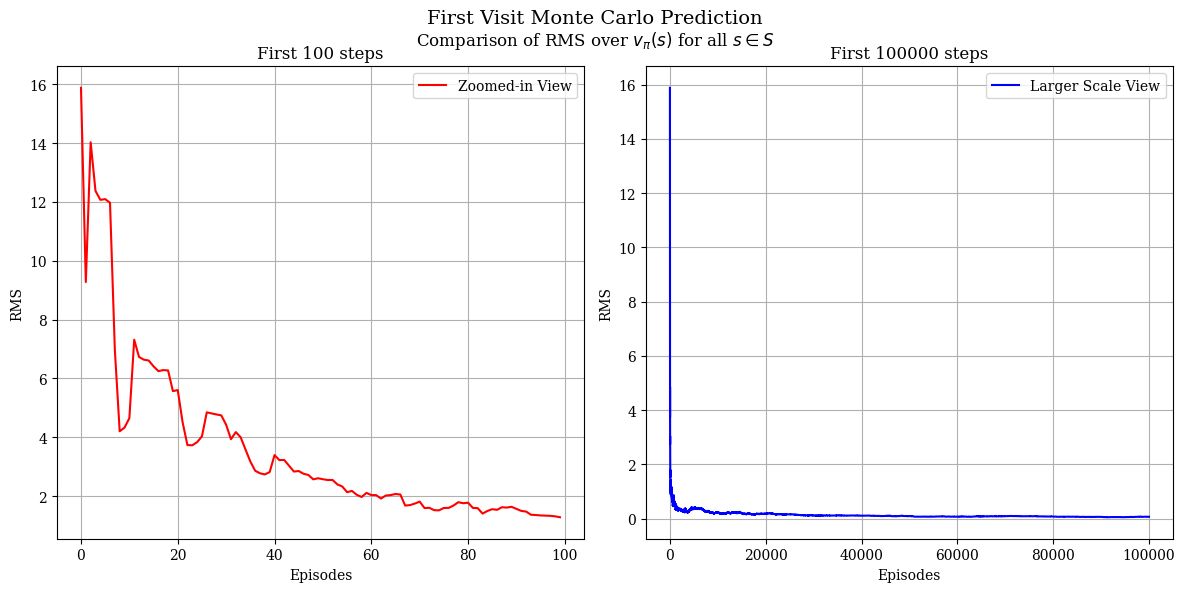

In [9]:
plot_v_rms(rms_over_time, 100, 100000)

### 4.2. Control

In [10]:
### 4.2.1 Cumulative rewards

The same map is used to evaluate control.

We use a random baseline over 10000 episodes, and a target of the average reward of an optimal policy. 

This average is taken to account for the random starts of our MDP.

In [11]:
"Random Baseline"
step_size = 1
steps = 10000
random_cumulative_rewards = []
for i in range(steps):
    episode = hb.Episode(mdp=demo_mdp, policy=random_policy)
    episode.run()
    random_cumulative_rewards.append(sum(episode.trajectory.rewards[1:])) # ignore NAN reward in initial state
    
avg_random_reward =  np.mean(random_cumulative_rewards)

In [12]:
"Optimal Rewards"
theta = 0.000_000_000_1
policy_iteration = hb.PolicyIteration(mdp=demo_mdp, theta_threshold=theta)
# Run PolicyIteration
pi_optimal_policy, pi_state_values, pi_q_values = policy_iteration.run()

step_size = 1
steps = 10000
optimal_cumulative_rewards = []
for i in range(steps):
    episode = hb.Episode(mdp=demo_mdp, policy=pi_optimal_policy)
    episode.run()
    optimal_cumulative_rewards.append(sum(episode.trajectory.rewards[1:]))
    
avg_optimal_reward = np.mean(optimal_cumulative_rewards)

We train the algorithm and run 100 episodes for each step in the training process. This to account for randomness.

In [25]:
step_size = 100
steps = 100
cumulative_rewards = []
mc_control = hb.MonteCarloController(demo_mdp, epsilon=0.3)
for i in range(steps):
    avg_cumulative_rewards = []
    mc_control.train(n_episodes=1)
    for s in range(step_size): 
        episode = hb.Episode(mdp=demo_mdp, policy=mc_control.policy)
        episode.run()
    
        avg_cumulative_rewards.append(sum(episode.trajectory.rewards[1:]))
    cumulative_rewards.append(np.mean(avg_cumulative_rewards))

The baselines and target are plotted together with the results for each epsilon.

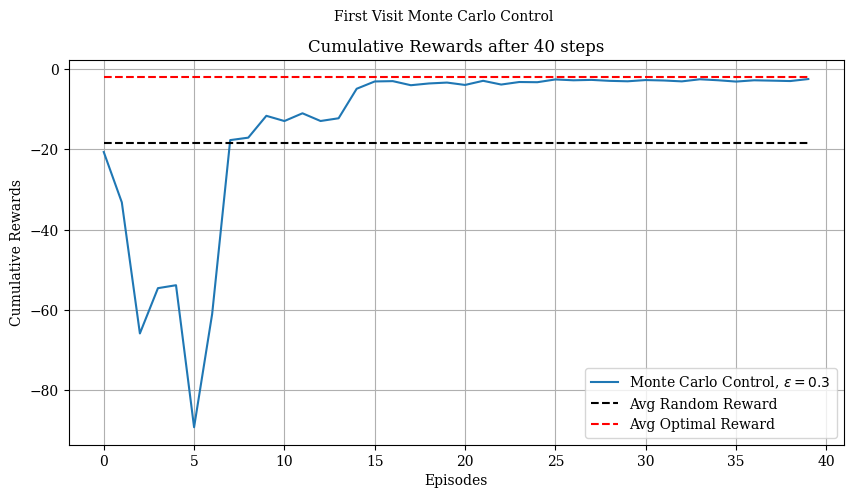

In [ ]:
import matplotlib.pyplot as plt

def plot_cumulative_rewards(cum_reward, 
                            avg_random_reward, avg_optimal_reward, stop):
    plt.figure(figsize=(10, 5))

    plt.plot(range(min(len(cum_reward), stop)), cum_reward[:stop], linestyle='-', label='Monte Carlo Control, $ \\epsilon=0.3$')
    plt.plot(range(min(len(cum_reward), stop)), [avg_random_reward] * stop, linestyle='--', color='black', label='Avg Random Reward')
    plt.plot(range(min(len(cum_reward), stop)), [avg_optimal_reward] * stop, linestyle='--', color='red', label='Avg Optimal Reward')

    plt.title(f'Cumulative Rewards after {stop} steps')
    plt.suptitle('First Visit Monte Carlo Control', fontsize=10)
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    
    plt.grid(True)
    plt.legend()

    plt.show()
plot_cumulative_rewards(cumulative_rewards, avg_random_reward, avg_optimal_reward, 50)

In [16]:
### 4.2.2 RMS over Q(s,a)

In [17]:
"""Ground truth based on Dynamic Programmign (See 4.2.1) """
exact_value_function = pi_q_values

We calculate the RMS over each Q(s,a) pair.

In [18]:
def calc_action_value_rms(truth, predicted):
    y = np.asarray([list(q.values()) for q in truth.values()])
    y_pred = np.asarray([list(q.values()) for q in predicted.values()])
    # Calculate RMS error for each Q(s,a)
    rms_per_q = np.sqrt(np.mean((y - y_pred) ** 2, axis=1))
    # Calculate the mean of the RMS errors
    return np.mean(rms_per_q)

We plot three different epsilons against each other.

In [19]:
steps = 10000
rms_over_time = []
def measure_action_value_rms(epsilon, steps):
    rms_over_time = []
    mc_controller = hb.MonteCarloController(demo_mdp, epsilon)
    for i in range(steps):
        mc_controller.train(1)

        rms_over_time.append(calc_action_value_rms(exact_value_function,  mc_controller.q_values))
    return rms_over_time

rms01 = measure_action_value_rms(0.1, steps)
rms03 = measure_action_value_rms(0.3, steps)
rms09 = measure_action_value_rms(0.9,steps)

Plot all these measurements, note the logarithmic scale.

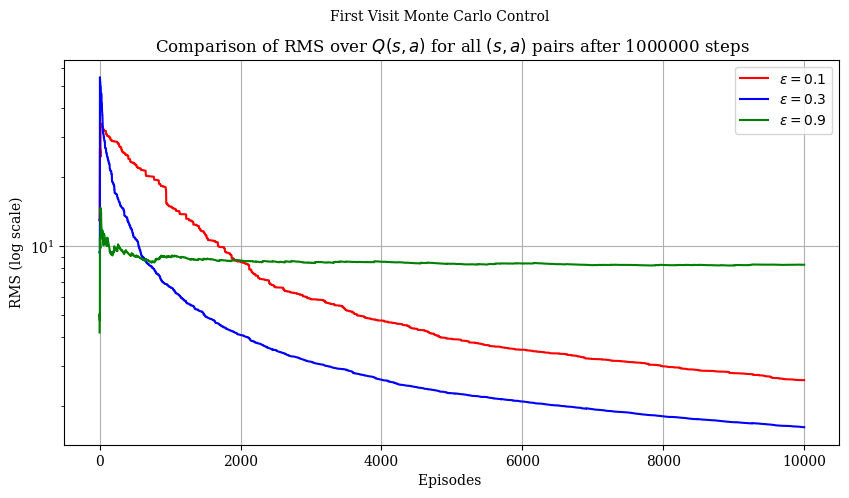

In [20]:
def plot_q_rms(rms1, rms2,rms3, total_steps):
    plt.figure(figsize=(10, 5))
 
    plt.plot(range(len(rms1)), rms1, linestyle='-', color="red", label="$\\epsilon=0.1$")

    plt.plot(range(len(rms2)), rms2, linestyle='-', color="blue", label="$\\epsilon=0.3$")

    plt.plot(range(len(rms3)), rms3, linestyle='-', color="green", label="$\\epsilon=0.9$")

    
    plt.title('Comparison of RMS over $Q(s, a)$ for all $(s, a)$ pairs' + f" after {total_steps} steps")
    plt.suptitle('First Visit Monte Carlo Control', fontsize=10)
    plt.xlabel(f'Episodes ')
    plt.ylabel('RMS (log scale)')

    plt.grid(True)
    plt.legend()
    plt.yscale("log")
    plt.show()


plot_q_rms(rms01, rms03,rms09, step_size*steps)